# This notebook contains the final project (Capstone) of the course IBM Data Science Professional Certificate

***

## Author: Eduardo Suarez
## February 2021


In [57]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


# Project: Viva Las Vegas Strip! Bet on investment 

#### The purpose of this project is to find the main hotels on the Las Vegas Strip and identify patterns in data nearby businesses (within a radius of 500 meters) to provide information to investors for decision-making on where to invest and in which business to invest. 

In [3]:
#Import necessary libraries

import pandas as pd # to read data into dataframe and data analysis
pd.options.display.max_rows=3000

import numpy as np  # vectorized analysis 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# Normalization data for clustering
from sklearn.preprocessing import StandardScaler 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# install wordcloud
!pip install wordcloud # Show visual representation of text data
from wordcloud import WordCloud #import package and its set

import json # library to handle JSON files
import requests # library to handle requests

!pip install geopy
!conda install -c conda-forge geopy --yes # Useful to Locate coordinates
import geopy
from geopy.geocoders import Photon # convert an address into latitude and longitude values

!pip install folium # Visualize geospatial data
import folium # map rendering library


print('Libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | ^C
/ Requirement already satisfied: folium in /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages (0.12.1)
Libraries imported.


# 1. Data Collection, Preparation and Cleaning

## 1.1. Collecting, preparing and cleaning data from the top hotels on the Las Vegas Strip 

In [45]:
# Let's read excel file of Las Vegas Strip hotels (Dataset obtained from url https://easy.vegas/casinos/list-interactive and transformed to excel 
# format (very few records ~ 30) )

# Fetch the file
my_file = project.get_file("Hotels Strip Las Vegas.xlsx")

# Read the xlsx data file from the object storage into a pandas DataFrame
my_file.seek(0)

df = pd.read_excel(my_file)

print('Shape',df.shape)

df

Shape (32, 6)


,Area,Name,Hotel price,rooms,Address,Zip code
0,Vegas Strip,Aria,$$$,4000,3730 S. Las Vegas Blvd,89158
1,Vegas Strip,Bally's,$$,2800,3645 S. Las Vegas Blvd,89109
2,Vegas Strip,Bellagio,$$$,4000,3600 S. Las Vegas Blvd,89109
3,Vegas Strip,Caesars Palace,$$$,4000,3570 S. Las Vegas Blvd,89109
4,Vegas Strip,Casino Royale,$$,150,3411 S. Las Vegas Blvd,89109
5,Vegas Strip,Circus Circus,$$,3800,2880 S. Las Vegas Blvd,89109
6,Vegas Strip,Cosmopolitan,$$$,3000,3708 S. Las Vegas Blvd,89109
7,Vegas Strip,Cromwell,$$$,200,3595 S. Las Vegas Blvd,89109
8,Vegas Strip,Delano,$$$,1100,3950 S. Las Vegas Blvd,89119
9,Vegas Strip,Encore at Wynn,$$$,2000,3131 S. Las Vegas Blvd,89109


In [46]:
# Now, We need to get the locations (latitude, longitude) of the hotels to use them through API Foursquare   

# I will try an example :

address = "3131 S. Las Vegas Blvd" # correspond to Encore at Wynn Hotel address

geolocator = Photon(user_agent="vegas_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of the Hotels are {}, {}.'.format(latitude, longitude))
print(location.address)

The coordinates of the Hotels are 36.3003758, -115.1362233.
Park Highlands Blvd, 89084, North Las Vegas, Nevada, United States


#### Note: The coordinates are not correct as they correspond to another address: Park Highlands Blvd, 89084, North Las Vegas, Nevada, United States.  Other address samples were processed and the coordinates were not correct.  

### Now, let's try to modify the address field to see if we can improve the accuracy of the coordinates:

In [47]:
# I modified the address structure by removing the word "Blvd" and 
# I used Photon geocoder instead Nominatim which did not show precise hotel locations this time.

address = "3131 S Las Vegas" # Encore at Wynn Hotel address

geolocator = Photon(user_agent="vegas_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of the Hotels are {}, {}.'.format(latitude, longitude))
print(location.address)

The coordinates of the Hotels are 36.1289345, -115.165362.
Encore Casino at Wynn, 3131, Las Vegas Boulevard S., 89109, Las Vegas Boulevard S., Las Vegas, NV, United States


#### Good! the geolocator provided the exact location (Encore at Wynn Hotel)

### Now, let's retrieve the locations of all hotels: 

In [65]:
# First, let's remove the word "Blvd" from the address column 
df['Address'] = df['Address'].str.replace('Blvd', '')

# Second, Let's add two columns to the dataframe (Latitude and Longitude) of float type
lat_lon_hot = df.assign(Latitude = float(), Longitude = float())

lat_lon_hot.tail(10)

,Area,Name,Hotel price,rooms,Address,Zip code,Latitude,Longitude
22,Vegas Strip,Park MGM,$$,2700,3770 S. Las Vegas .,89109,0.0,0.0
23,Vegas Strip,Planet Hollywood,$$,2600,3667 S. Las Vegas,89109,0.0,0.0
24,Vegas Strip,Sahara,$$,1600,2535 S. Las Vegas,89109,0.0,0.0
25,Vegas Strip,Strat,$$,1500,2000 S. Las Vegas,89103,0.0,0.0
26,Vegas Strip,Treasure Island,$$,2900,3300 S. Las Vegas,89109,0.0,0.0
27,Vegas Strip,Tropicana,$$,1900,3801 S. Las Vegas,89109,0.0,0.0
28,Vegas Strip,Vdara,$$$,1500,2600 W Harmon Avenue,89158,0.0,0.0
29,Vegas Strip,Venetian,$$$,4000,3355 S. Las Vegas,89109,0.0,0.0
30,Vegas Strip,Waldorf Astoria,$$$,400,3752 S. Las Vegas,89109,0.0,0.0
31,Vegas Strip,Wynn,$$$,2700,3131 S. Las Vegas,89109,0.0,0.0


## Note:  Investors will focus on business in areas of hotels with large capacity, therefore small hotels on the Strip will not be taken in this project. Waldorf Astoria, although it is small, its location and number of rooms are important. 

In [67]:
# Let's eliminate the rows for hotels with low room capacity (rooms < 400) in the dataframe.

lat_lon_hot.drop(lat_lon_hot[lat_lon_hot['rooms']<400].index, inplace=True)

lat_lon_ = lat_lon_hot.reset_index(drop=True)

print('Now our Dataframe has 29 hotels instead of 32')

lat_lon_

Now our Dataframe has 29 hotels instead of 32


,Area,Name,Hotel price,rooms,Address,Zip code,Latitude,Longitude
0,Vegas Strip,Aria,$$$,4000,3730 S. Las Vegas,89158,0.0,0.0
1,Vegas Strip,Bally's,$$,2800,3645 S. Las Vegas,89109,0.0,0.0
2,Vegas Strip,Bellagio,$$$,4000,3600 S. Las Vegas,89109,0.0,0.0
3,Vegas Strip,Caesars Palace,$$$,4000,3570 S. Las Vegas,89109,0.0,0.0
4,Vegas Strip,Circus Circus,$$,3800,2880 S. Las Vegas,89109,0.0,0.0
5,Vegas Strip,Cosmopolitan,$$$,3000,3708 S. Las Vegas,89109,0.0,0.0
6,Vegas Strip,Delano,$$$,1100,3950 S. Las Vegas,89119,0.0,0.0
7,Vegas Strip,Encore at Wynn,$$$,2000,3131 S. Las Vegas,89109,0.0,0.0
8,Vegas Strip,Excalibur,$$,4000,3850 S. Las Vegas,89109,0.0,0.0
9,Vegas Strip,Flamingo,$$,3700,3555 S. Las Vegas,89109,0.0,0.0


In [68]:
# Third, Let's create loop to retrieve latitude and longitude of the hotels and update to dataframe  

for i in range(len(lat_lon_)):

    address = lat_lon_['Address'][i]

    geolocator = Photon(user_agent="vegas_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The coordinates of the Hotel are {}, {}.'.format(latitude, longitude))
    print(location.address)
    lat_lon_['Latitude'][i] = latitude
    lat_lon_['Longitude'][i] = longitude


The coordinates of the Hotel are 36.1070349, -115.17797577544002.
Aria Resort & Casino, 3730, Las Vegas Boulevard, 89109, Las Vegas Boulevard, Las Vegas, NV, United States


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The coordinates of the Hotel are 36.1137843, -115.16901066671255.
Bally's Las Vegas, 3645, Las Vegas Boulevard South, 89109, Las Vegas Boulevard South, Las Vegas, NV, United States
The coordinates of the Hotel are 36.113114949999996, -115.17700645228665.
Bellagio Las Vegas, 3600, South Las Vegas Boulevard, 89109, South Las Vegas Boulevard, Las Vegas, NV, United States
The coordinates of the Hotel are 36.116627699999995, -115.17675676624611.
Caesars Palace, 3570, Las Vegas Boulevard, 89109, Las Vegas Boulevard, Las Vegas, NV, United States
The coordinates of the Hotel are 36.137719849999996, -115.1658457656757.
Circus Circus Las Vegas, 2880, Las Vegas Blvd, 89109, Las Vegas Blvd, Las Vegas, NV, United States
The coordinates of the Hotel are 36.11015665, -115.17409147576456.
The Cosmopolitan of Las Vegas, 3708, South Las Vegas Boulevard, 89109, South Las Vegas Boulevard, Las Vegas, NV, United States
The coordinates of the Hotel are 36.0905123, -115.175916.
Bikini Bar, 3950, South Las Veg

In [69]:
# Let's look at what the data frame looks like 

lat_lon_

,Area,Name,Hotel price,rooms,Address,Zip code,Latitude,Longitude
0,Vegas Strip,Aria,$$$,4000,3730 S. Las Vegas,89158,36.107035,-115.177976
1,Vegas Strip,Bally's,$$,2800,3645 S. Las Vegas,89109,36.113784,-115.169011
2,Vegas Strip,Bellagio,$$$,4000,3600 S. Las Vegas,89109,36.113115,-115.177006
3,Vegas Strip,Caesars Palace,$$$,4000,3570 S. Las Vegas,89109,36.116628,-115.176757
4,Vegas Strip,Circus Circus,$$,3800,2880 S. Las Vegas,89109,36.137720,-115.165846
5,Vegas Strip,Cosmopolitan,$$$,3000,3708 S. Las Vegas,89109,36.110157,-115.174091
6,Vegas Strip,Delano,$$$,1100,3950 S. Las Vegas,89119,36.090512,-115.175916
7,Vegas Strip,Encore at Wynn,$$$,2000,3131 S. Las Vegas,89109,36.128934,-115.165362
8,Vegas Strip,Excalibur,$$,4000,3850 S. Las Vegas,89109,36.098873,-115.175608
9,Vegas Strip,Flamingo,$$,3700,3555 S. Las Vegas,89109,36.116425,-115.172364


### Let's visualize the coordinates of the Hotels using Folium. 

In [70]:
# create map of Las Vegas, Strip
map_Strip = folium.Map(location=[36.1175584, -115.2014624], zoom_start=10) # Coordinates obtained in Google Maps

# add Hotels to map
for lati, lngi, names1 in zip(lat_lon_['Latitude'], lat_lon_['Longitude'], lat_lon_['Name']):
    label = names1
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Strip)  

map_Strip

#### Note: Checking the map by hotel, we could detect that there were four hotels (Mandalay Bay, Delano, Palazzo and Wynn) with wrong coordinates pointing to other locations.

### Now, We will update the correct coordinates in the dataframe for this hotels (Coordinates obtained in Google Maps)

In [71]:
lat_lon_.iloc[14,6] = 36.0919631 ; lat_lon_.iloc[14,7] = -115.1771313 # Update coordinates Mandalay Bay
lat_lon_.iloc[17,6] = 36.1239948 ; lat_lon_.iloc[17,7] = -115.1680944 # Update coordinates Palazzo
lat_lon_.iloc[6,6] = 36.0926392; lat_lon_.iloc[6,7] = -115.1777734 # Update coordinates Delano
lat_lon_.iloc[28,6] = 36.1265725 ; lat_lon_.iloc[28,7] = -115.1660416 # Update coordinates Wynn

print('Coordinates updated')

lat_lon_.iloc[['6','14','17','28']]

Coordinates updated


,Area,Name,Hotel price,rooms,Address,Zip code,Latitude,Longitude
6,Vegas Strip,Delano,$$$,1100,3950 S. Las Vegas,89119,36.092639,-115.177773
14,Vegas Strip,Mandalay Bay,$$$,3300,3950 S. Las Vegas,89119,36.091963,-115.177131
17,Vegas Strip,Palazzo,$$$,3000,3265 S. Las Vegas,89109,36.123995,-115.168094
28,Vegas Strip,Wynn,$$$,2700,3131 S. Las Vegas,89109,36.126573,-115.166042


### Let's visualize again the coordinates of the Hotels using Folium to verify coordinates.

In [72]:
# create map of Las Vegas, Strip
map_Strip = folium.Map(location=[36.1175584, -115.2014624], zoom_start=10) # Coordinates obtained in Google Maps

# add Hotels to map
for lati, lngi, names1 in zip(lat_lon_['Latitude'], lat_lon_['Longitude'], lat_lon_['Name']):
    label = names1
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Strip)  

map_Strip

#### Good! All hotels are now on the Strip which is an area or a strip that goes from north to south in Las Vegas and coodinates are correct.

In [73]:
# Let's rename 'Name' variable to 'Hotel' and drop 'Area Strip' variable 

lat_lon_.rename(columns={'Name': 'Hotel','Hotel price':'Price'}, inplace=True)

del lat_lon_['Area'] # repeated values of the 'Vegas Strip'

# The 'Price' feature has categorical data with $$ (medium price) and $$$ (high price).We are going to update this data

lat_lon_.replace({'$$': 'medium', '$$$':'high'},inplace=True)

lat_lon_.head()

,Hotel,Price,rooms,Address,Zip code,Latitude,Longitude
0,Aria,high,4000,3730 S. Las Vegas,89158,36.107035,-115.177976
1,Bally's,medium,2800,3645 S. Las Vegas,89109,36.113784,-115.169011
2,Bellagio,high,4000,3600 S. Las Vegas,89109,36.113115,-115.177006
3,Caesars Palace,high,4000,3570 S. Las Vegas,89109,36.116628,-115.176757
4,Circus Circus,medium,3800,2880 S. Las Vegas,89109,36.137720,-115.165846


In [74]:
# Let's export data to CSV file

project.save_data("coord_hotels.csv", lat_lon_.to_csv(index=False),overwrite=True)

print('Data exported successfully')

Data exported successfully


### Upload data for pre-processing  later

In [75]:
# Read new stored file 

# Fetch the file
my_file2 = project.get_file("coord_hotels.csv")

# Read the csv data file from the object storage into a pandas DataFrame
my_file2.seek(0)

coord_hotels = pd.read_csv(my_file2)

print('Shape',coord_hotels.shape)

coord_hotels.head()

Shape (29, 7)


,Hotel,Price,rooms,Address,Zip code,Latitude,Longitude
0,Aria,high,4000,3730 S. Las Vegas,89158,36.107035,-115.177976
1,Bally's,medium,2800,3645 S. Las Vegas,89109,36.113784,-115.169011
2,Bellagio,high,4000,3600 S. Las Vegas,89109,36.113115,-115.177006
3,Caesars Palace,high,4000,3570 S. Las Vegas,89109,36.116628,-115.176757
4,Circus Circus,medium,3800,2880 S. Las Vegas,89109,36.137720,-115.165846


## 1.2. Collecting information from hotels and nearby businesses through Foursquare (Explore Venue API) and preparing and cleaning data

### Let's use the coordinates to collect information about Hotels and Businesses (Venues) in Foursquare.

### As Foursquare searches for businesses or venues near a given coordinate, the retrieved data will contain information on both hotels and businesses near them.

In [76]:
# First, We are going to create a loop to retrieve information about Hotels and Business. 


def getIDhot_buss(names, latitudes, longitudes, radius=500):
    
    id_list=[]
   
    for name, lat, lng in zip(names, latitudes, longitudes):
                           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
                       
        # make the GET request for venues
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information
        id_list.append([(
            name,
            v['venue']['id'],
            v['venue']['name'],
            v['venue']['location']['distance'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
        # make the GET request for total results
        results_= requests.get(url).json()
        print (name,'/','Total Venues:',results_['response']['totalResults']) # Total venues
            
    id_hot_buss = pd.DataFrame([item for venue_list in id_list for item in venue_list])
    id_hot_buss.columns = ['Name',
                  'Venue ID',
                  'Venue',
                  'Distance',
                  'Latitude',
                  'Longitude',
                  'Venue Category']    
              
    return(id_hot_buss)

In [77]:
# Second, Let's retrieve the ID's, Names, Categories and Distance of the hotels y Business using the created function getIDhot_buss

hot_buss_ID = getIDhot_buss(names=coord_hotels['Hotel'],
                                   latitudes=coord_hotels['Latitude'],
                                   longitudes=coord_hotels['Longitude']
    
                        )

print('Data loaded successfully')

Aria / Total Venues: 115
Bally's / Total Venues: 142
Bellagio / Total Venues: 130
Caesars Palace / Total Venues: 147
Circus Circus / Total Venues: 51
Cosmopolitan / Total Venues: 181
Delano / Total Venues: 108
Encore at Wynn / Total Venues: 91
Excalibur / Total Venues: 54
Flamingo / Total Venues: 132
Harrah's / Total Venues: 109
The Linq / Total Venues: 104
Luxor / Total Venues: 58
MGM Grand / Total Venues: 124
Mandalay Bay / Total Venues: 107
Mirage / Total Venues: 121
New York New York / Total Venues: 122
Palazzo / Total Venues: 148
Paris / Total Venues: 139
Park MGM / Total Venues: 129
Planet Hollywood / Total Venues: 145
Sahara / Total Venues: 39
Strat / Total Venues: 65
Treasure Island / Total Venues: 123
Tropicana / Total Venues: 53
Vdara / Total Venues: 133
Venetian / Total Venues: 92
Waldorf Astoria / Total Venues: 157
Wynn / Total Venues: 113
Data loaded successfully


### Now, Let's export the data to CSV file

In [79]:
# Let's export data to CSV file

project.save_data("hot_buss_ID.csv", hot_buss_ID.to_csv(index=False),overwrite=True)

print('Data exported successfully')


Data exported successfully


In [81]:
# Read new stored file 

# Fetch the file
my_file3 = project.get_file("hot_buss_ID.csv")

# Read the csv data file from the object storage into a pandas DataFrame
my_file3.seek(0)

ID_hotbuss = pd.read_csv(my_file3)

print('Shape',ID_hotbuss.shape)

ID_hotbuss.head(10)

Shape (2603, 7)


,Name,Venue ID,Venue,Distance,Latitude,Longitude,Venue Category
0,Aria,4ba5559ef964a520f7fb38e3,ARIA Pool & Cabanas,33,36.106782,-115.178182,Pool
1,Aria,4bca06ce0687ef3b8c10dbcc,ARIA Sky Suites & Villas,94,36.106889,-115.176939,Hotel
2,Aria,4d6002d8d7206ea8c5a7eff1,ARIA Gym,60,36.107071,-115.178649,Gym / Fitness Center
3,Aria,5bd7afa4446ea6002cdaf615,Catch,186,36.107850,-115.176161,Seafood Restaurant
4,Aria,544ab12a498ee155461750be,BARDOT Brasserie,129,36.107349,-115.176584,French Restaurant
5,Aria,506a208ae4b0821d12919ac3,Javier's Mexican Restaurant Las Vegas,129,36.107349,-115.176584,Mexican Restaurant
6,Aria,4ae61edbf964a520dfa421e3,ARIA Resort & Casino,150,36.107847,-115.176639,Hotel
7,Aria,4d5dba93d979ba7a5a4db4c7,Market Café Vdara,157,36.108352,-115.177332,Café
8,Aria,4b29433ef964a520eb9b24e3,Julian Serrano Tapas,198,36.107877,-115.176026,Spanish Restaurant
9,Aria,55e3dbce498eececab4516b0,Pressed Juicery,103,36.106667,-115.176920,Juice Bar


# 2. Exploratory Data Analysis 

## 2.1. Let's first explore our first dataset of the top hotels on the Las Vegas Strip. 

In [82]:
coord_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Hotel      29 non-null     object 
 1   Price      29 non-null     object 
 2   rooms      29 non-null     int64  
 3   Address    29 non-null     object 
 4   Zip code   29 non-null     int64  
 5   Latitude   29 non-null     float64
 6   Longitude  29 non-null     float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.7+ KB


In [83]:
coord_hotels.head()

,Hotel,Price,rooms,Address,Zip code,Latitude,Longitude
0,Aria,high,4000,3730 S. Las Vegas,89158,36.107035,-115.177976
1,Bally's,medium,2800,3645 S. Las Vegas,89109,36.113784,-115.169011
2,Bellagio,high,4000,3600 S. Las Vegas,89109,36.113115,-115.177006
3,Caesars Palace,high,4000,3570 S. Las Vegas,89109,36.116628,-115.176757
4,Circus Circus,medium,3800,2880 S. Las Vegas,89109,36.137720,-115.165846


### We are going to group the hotels by number of rooms and showing appreciative room prices by levels (low-medium-high)

Text(0, 0.5, 'Hotel, Price')

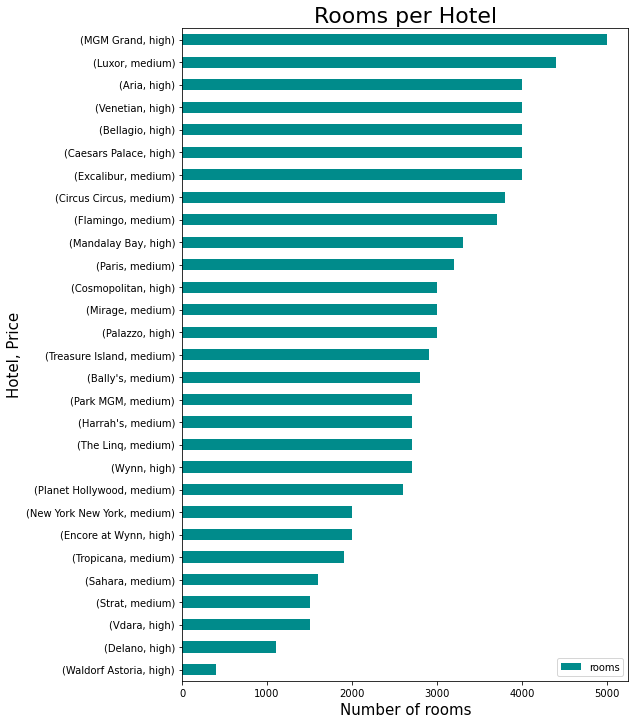

In [84]:
# Grouping and visualization of the data
hotels_rooms = coord_hotels.iloc[:, 0:3].groupby(['Hotel','Price'])[['rooms']].sum(
).sort_values('rooms').plot.barh(figsize=(8, 12),color= 'darkcyan')

plt.title('Rooms per Hotel',size=22)
plt.xlabel('Number of rooms',size=15)
plt.ylabel('Hotel, Price', size=15)

### Now, we will visualize the hotels according to their accommodation capacity using Folium. 

In [85]:
# create map of Las Vegas, Strip
map_Strip = folium.Map(location=[36.1175584, -115.2014624], zoom_start=10) # Coordinates obtained in Google Maps

# add Hotels to map
for lati, lngi, names1,rooms in zip(coord_hotels['Latitude'], coord_hotels['Longitude'], coord_hotels['Hotel'],coord_hotels['rooms']):
    label = names1
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lati, lngi],
        radius=0.03*rooms,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_Strip)  

map_Strip

## 2.2. Let's explore our second dataset for businesses near hotels 

In [86]:
ID_hotbuss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            2603 non-null   object 
 1   Venue ID        2603 non-null   object 
 2   Venue           2603 non-null   object 
 3   Distance        2603 non-null   int64  
 4   Latitude        2603 non-null   float64
 5   Longitude       2603 non-null   float64
 6   Venue Category  2603 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 142.5+ KB


### Summarizing the data to understand it better. 

In [87]:
ID_hotbuss.describe(include='all')

,Name,Venue ID,Venue,Distance,Latitude,Longitude,Venue Category
count,2603,2603,2603,2603.000000,2603.000000,2603.000000,2603
unique,29,925,864,NaN,NaN,NaN,166
top,Flamingo,53054fd5498e2d9d5a17a5b9,Starbucks,NaN,NaN,NaN,Hotel
freq,100,7,19,NaN,NaN,NaN,186
mean,NaN,NaN,NaN,291.230119,36.113537,-115.172092,NaN
std,NaN,NaN,NaN,128.162502,0.012260,0.004783,NaN
min,NaN,NaN,NaN,4.000000,36.087974,-115.181944,NaN
25%,NaN,NaN,NaN,192.000000,36.105534,-115.175530,NaN
50%,NaN,NaN,NaN,309.000000,36.112758,-115.172997,NaN
75%,NaN,NaN,NaN,396.000000,36.121181,-115.169979,NaN


### Let's analyze 'Name' and 'Venue' features (main hotels on the Las Vegas Strip and their nearby business)

Text(0, 0.5, 'Number of nearby venues')

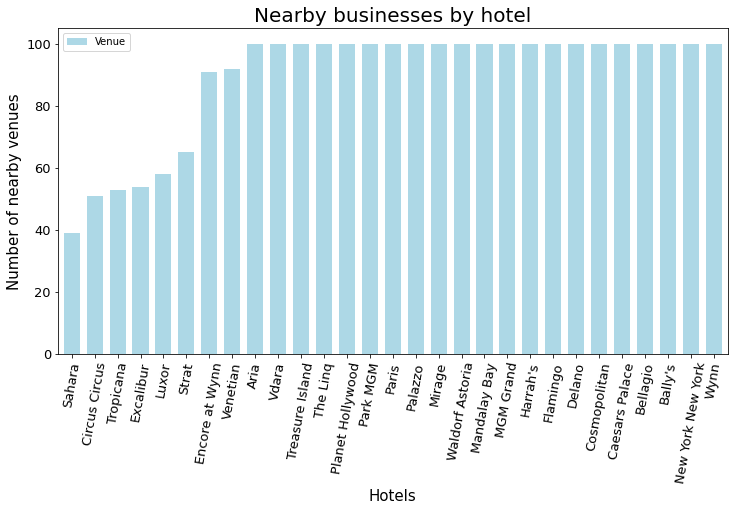

In [88]:
## Let's rename the [Name] column to Hotel and grouping by Hotel

ID_hotbuss.rename(columns={'Name': 'Hotel'}, inplace=True)

# Grouping Hotels
Hotels_group = ID_hotbuss.groupby(['Hotel'])[['Venue']
                                            ].count().sort_values(by='Venue').plot.bar(fontsize = 13, 
                                            figsize=(12, 6),rot=80, color='lightblue',width=0.7)

plt.title('Nearby businesses by hotel',size=20)
plt.xlabel('Hotels',size=15)
plt.ylabel('Number of nearby venues',size=15)

#### Note:  According to the data previously retrieved through Foursquare API, most hotels had more than 100 venues, however, Foursquare limits a maximum of 100 venues per coordinate given. For the purposes of this project we will only use the maximum limit allowed by coordinate.

### Let's analyze the unique values of the 'Venue ID' feature (925 of 2597 records)

In [89]:
# Replace column name
ID_hotbuss.rename(columns={'Venue Category': 'Category'}, inplace=True) 

ID_hotbuss.groupby(['Venue ID']).count().head() # Grouping by Venue ID


,Hotel,Venue,Distance,Latitude,Longitude,Category
Venue ID,,,,,,
41326e00f964a52006141fe3,1,1,1,1,1,1
41326e00f964a52038151fe3,6,6,6,6,6,6
41326e00f964a52057141fe3,3,3,3,3,3,3
41326e00f964a52067151fe3,4,4,4,4,4,4
41326e00f964a52069151fe3,1,1,1,1,1,1


#### Note: We can see that the Venue ID variable has duplicate values, we will analyze this in the next step. 

## We are going to group the data until we obtain a single record per row of the variable "Venue ID" (break down)

In [90]:
groups_byID = ID_hotbuss.groupby(['Venue ID','Venue','Category','Hotel','Distance']).count()   

groups_byID.head(10)

Latitude  \
Venue ID                 Venue                          Category    Hotel             Distance             
41326e00f964a52006141fe3 Coyote Ugly Saloon - Las Vegas Bar         New York New York 92               1   
41326e00f964a52038151fe3 Venetian Resort & Casino       Casino      Harrah's          386              1   
                                                                    Mirage            455              1   
                                                                    Palazzo           238              1   
                                                                    The Linq          483              1   
                                                                    Treasure Island   267              1   
                                                                    Venetian          132              1   
41326e00f964a52057141fe3 House of Blues                 Music Venue Delano            191              1   
                                                                    Luxor             317              1   
                                                                    Mandalay Bay      174              1   

                                                                                                Longitude  
Venue ID                 Venue                          Category    Hotel             Distance             
41326e00f964a52006141fe3 Coyote Ugly Saloon - Las Vegas Bar         New York New York 92                1  
41326e00f964a52038151fe3 Venetian Resort & Casino       Casino      Harrah's          386               1  
                                                                    Mirage            455               1  
                                                                    Palazzo           238               1  
                                                                    The Linq          483               1  
                                                                    Treasure Island   267               1  
                                                                    Venetian          132               1  
41326e00f964a52057141fe3 House of Blues                 Music Venue Delano            191               1  
                                                                    Luxor             317               1  
                                                                    Mandalay Bay      174               1

#### Note: As we can see above, the Venue ID variable is repeated for more than one hotel, this due that the same business has a relative distance to each hotel on the Strip due to the proximity of the hotels to each other. 

### Now, we will visualize the data of the 'Category' field. According to the summary, there are 165 unique values associated with categories. Let's analyze this data. 

In [91]:
# Let's group data by Category

ID_hotbuss.groupby(['Category']).count().tail(10)


,Hotel,Venue ID,Venue,Distance,Latitude,Longitude
Category,,,,,,
Theme Park Ride / Attraction,21,21,21,21,21,21
Theme Restaurant,13,13,13,13,13,13
Tourist Information Center,5,5,5,5,5,5
Toy / Game Store,4,4,4,4,4,4
Travel Lounge,3,3,3,3,3,3
Volcano,5,5,5,5,5,5
Wings Joint,7,7,7,7,7,7
Women's Store,18,18,18,18,18,18
Zoo,5,5,5,5,5,5


#### Note: Carrying out a quick inspection in this dataframe, we could observe that there are categories that do not apply to our business case, for example, amusement parks, swimming pools, zoo etc. In the next step we will filter these businesses to exclude them from the data. 

#### Also, our 'Category' feature has duplicate values since the same business is repeated for different hotels due to the proximity variable 'Distance'. For this analysis we will create a DataFrame with unique values of Venue ID feature.

In [92]:
# Create dataframe with unique values 
uniques_ID = ID_hotbuss.drop_duplicates('Venue ID')

# We are going to exclude businesses or venues that do not add value to our case study. 
no_list = ['Hotel','Resort','Pool','Casino','Theater','Hotel Pool','Aquarium',
           'Art Gallery','Auto Garage','Boat or Ferry','Botanical Garden','Bus Stop',
           'Business Service','Canal','Comedy Club','Concert Hall','Fountain','Garden',
           'General Entertainment','History Museum','Hockey Arena','Indie Theater','Intersection',
           'Light Rail Station','Movie Theater','Museum','Parking','Pedestrian Plaza','Performing Arts Venue',
           'Plaza','Public Art','Roof Deck','Scenic Lookout','Science Museum','Sculpture Garden','Shopping Mall',
           'Speakeasy','Stadium','Theme Park','Theme Park Ride / Attraction','Tourist Information Center','Volcano',
           'Zoo','Zoo Exhibit']

uniques_cat = uniques_ID[~uniques_ID.Category.isin(no_list)] # Uniques categories

categories = uniques_cat['Category'].values
categories.shape

(660,)

### Let's use the "Word Cloud" visualization technique to better visualize the most frequent businesses or venues by category. 

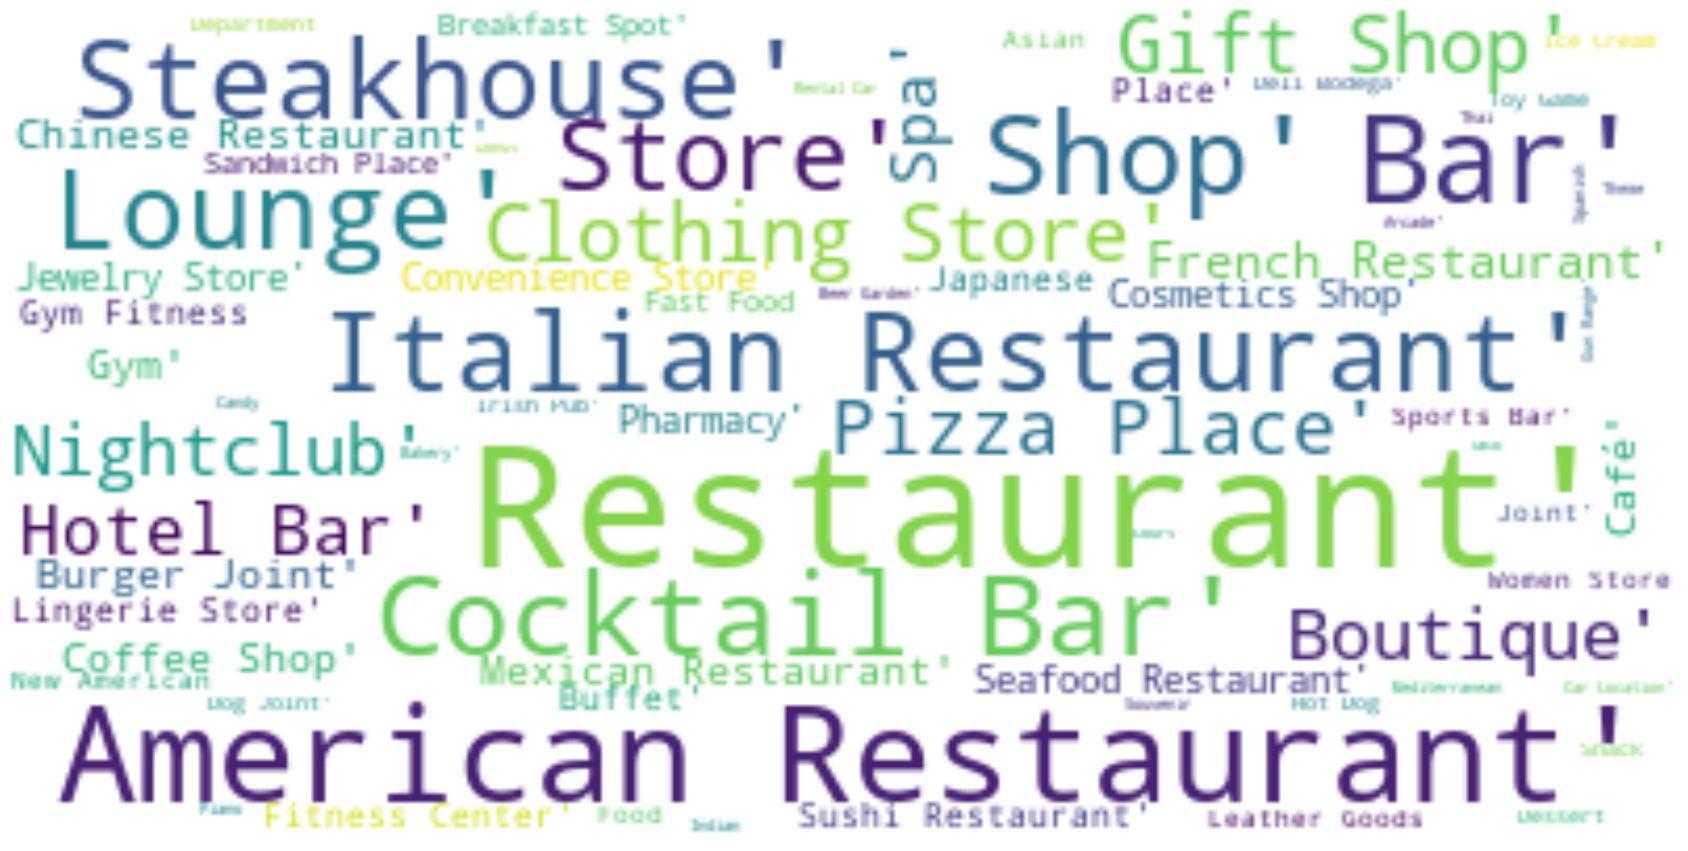

In [93]:
# figure size
fig = plt.figure()
fig.set_figwidth(30) # set width
fig.set_figheight(20) # set height

# instantiate a word cloud object
cat_group = WordCloud(background_color='white')

cat_group.generate(str(categories))

# display the word cloud
plt.imshow(cat_group, interpolation='bilinear')
plt.axis('off')

plt.show()

### We will analyze the 'Distance' feature. This represents the distance in meters of each business with respect to each hotel in a range of 0-500 meters. 

Text(0, 0.5, 'Distance in meters')

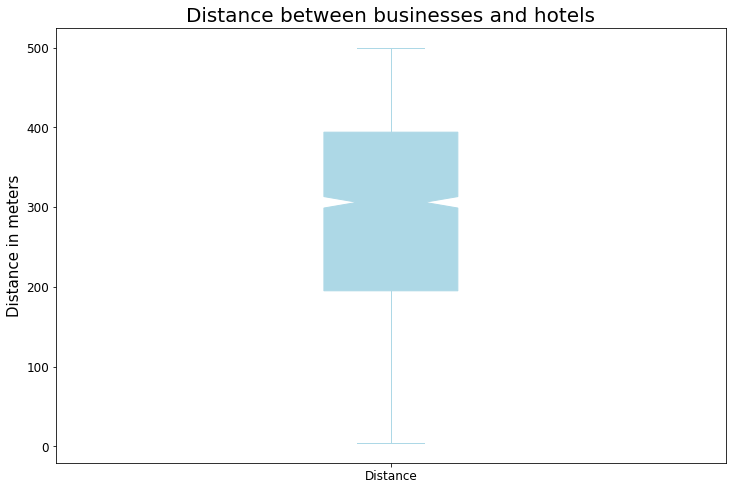

In [94]:
distance_val = ID_hotbuss[~ID_hotbuss.Category.isin(no_list)]

distance_buss = distance_val[['Distance']]

distance_range = distance_buss.plot.box(figsize=(12,8),color='lightblue',widths=0.2,
                                       patch_artist=True,notch=True,fontsize=12)

plt.title('Distance between businesses and hotels',fontsize=20)
plt.ylabel('Distance in meters',fontsize=15)

Text(0.5, 0, 'Distance (meters)')

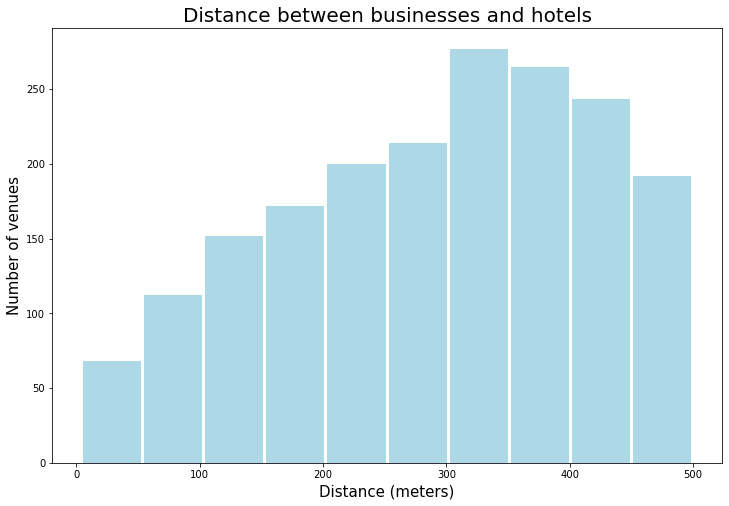

In [95]:
# Let's create a histogram to see better the distribution

distance_buss.hist(color='lightblue',figsize=(12,8),rwidth=0.95, grid=False)

plt.title('Distance between businesses and hotels', fontsize=20)
plt.ylabel('Number of venues',fontsize=15)
plt.xlabel('Distance (meters)',fontsize=15)

#### Note: 
#### Distance between businesses and the coordinates of the hotels:

#### 25% of the businesses (~470 businesses) are at a radial distance between 0 and 200 meters from the coordinates of the hotels

#### 25% of the businesses (~470 businesses) are at a radial distance between 400 and 500 meters from the coordinates of the hotels

#### 50% of the businesses (~940 businesses) are at radial a distance >200 and <400 meters from the coordinates of the hotels 

# 3. Data preparation and analysis for our clustering model 
### We will use the features "Distance", Category" and 'Price' for our clustering model.

## 3.1. Feature Engineering

In [96]:
# Creation of dataframe (Distance and Category) for preparation and analysis.

model_data_1 = distance_val[['Hotel','Distance','Category']].reset_index(drop=True)

model_data_1.head()
                       

,Hotel,Distance,Category
0,Aria,60,Gym / Fitness Center
1,Aria,186,Seafood Restaurant
2,Aria,129,French Restaurant
3,Aria,129,Mexican Restaurant
4,Aria,157,Café


### One Hot encoding
#### Convert our qualitative data into quantitative 

In [97]:
# One Hot encoding 'Category' feature (dataset ID_hotbuss)
model_data_onehot_1 = pd.get_dummies(model_data_1[['Category']], prefix="", prefix_sep="")

# add Hotel column back to dataframe
model_data_onehot_1['Hotel'] = model_data_1['Hotel'] 

# move Hotel column to the first column
fixed_columns = [model_data_onehot_1.columns[-1]] + list(model_data_onehot_1.columns[:-1])
model_data_onehot_1 = model_data_onehot_1[fixed_columns]

model_data_onehot_1.head()

,Hotel,Accessories Store,Advertising Agency,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theme Restaurant,Toy / Game Store,Travel Lounge,Wings Joint,Women's Store
0,Aria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# Let's group the data by averaging the frequency of occurrence of the categories 

hotels_data_model_grouped = model_data_onehot_1.groupby('Hotel').mean().reset_index()

hotels_data_model_grouped.head()

,Hotel,Accessories Store,Advertising Agency,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theme Restaurant,Toy / Game Store,Travel Lounge,Wings Joint,Women's Store
0,Aria,0.0,0.0,0.014286,0.000000,0.000000,0.014286,0.000000,0.000000,0.0,...,0.0,0.0,0.014286,0.0,0.014286,0.000000,0.0,0.0,0.0,0.014286
1,Bally's,0.0,0.0,0.044776,0.000000,0.014925,0.000000,0.014925,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.014925,0.014925,0.0,0.0,0.0,0.014925
2,Bellagio,0.0,0.0,0.014286,0.000000,0.000000,0.014286,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.014286,0.0,0.0,0.0,0.014286
3,Caesars Palace,0.0,0.0,0.041096,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.027397,0.0,0.0,0.0,0.041096
4,Circus Circus,0.0,0.0,0.071429,0.071429,0.000000,0.000000,0.000000,0.035714,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [99]:
# One Hot encoding 'Price' feature (dataset coord_hotels)
model_data_onehot_2 = pd.get_dummies(coord_hotels[['Price']], prefix="", prefix_sep="")

# add Hotel column back to dataframe
model_data_onehot_2['Hotel'] = coord_hotels['Hotel'] 

# move Hotel column to the first column
fixed_columns = [model_data_onehot_2.columns[-1]] + list(model_data_onehot_2.columns[:-1])
model_data_onehot_2 = model_data_onehot_2[fixed_columns]

# rename columuns
model_data_onehot_2.rename(columns={'high': 'high_price','medium':'medium_price'}, inplace=True)

model_data_onehot_2.head()

,Hotel,high_price,medium_price
0,Aria,1,0
1,Bally's,0,1
2,Bellagio,1,0
3,Caesars Palace,1,0
4,Circus Circus,0,1


### Binning features

#### Now, we are going to divide the "Distance" feature into three new features that we call minimum, medium(average) and maximum. 

#### This is because each Hotel has more than one distance (meters) per category associated with all businesses. 

In [100]:
minimum = model_data_1.groupby(['Hotel'])[['Distance']].min(); minimum.rename(columns={'Distance': 'minimum_distance'},inplace=True)
minimum.head(2)

,minimum_distance
Hotel,
Aria,43
Bally's,26


In [101]:
medium = model_data_1.groupby(['Hotel'])[['Distance']].mean(); medium.rename(columns={'Distance': 'medium_distance'},inplace=True)
medium.head(2)

,medium_distance
Hotel,
Aria,312.514286
Bally's,305.119403


In [102]:
maximum = model_data_1.groupby(['Hotel'])[['Distance']].max(); maximum.rename(columns={'Distance': 'maximum_distance'},inplace=True)
maximum.head(2)

,maximum_distance
Hotel,
Aria,493
Bally's,500


In [103]:
# We create a dataframe with the three new features.

model_data_2 = pd.concat([minimum,medium,maximum],axis=1).reset_index()

model_data_2.head()

,Hotel,minimum_distance,medium_distance,maximum_distance
0,Aria,43,312.514286,493
1,Bally's,26,305.119403,500
2,Bellagio,19,314.657143,497
3,Caesars Palace,65,304.205479,481
4,Circus Circus,33,203.321429,499


### Finally, we join the dataframes with the categories, distances and prices for each Hotel. 

In [104]:
# Join dataframes

hotels_data_model = pd.concat([hotels_data_model_grouped, model_data_onehot_2.drop(['Hotel'],axis=1), model_data_2.drop(['Hotel'],axis=1)],axis=1)

In [105]:
hotels_data_model

,Hotel,Accessories Store,Advertising Agency,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Theme Restaurant,Toy / Game Store,Travel Lounge,Wings Joint,Women's Store,high_price,medium_price,minimum_distance,medium_distance,maximum_distance
0,Aria,0.000000,0.000000,0.014286,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.014286,1,0,43,312.514286,493
1,Bally's,0.000000,0.000000,0.044776,0.000000,0.014925,0.000000,0.014925,0.000000,0.000000,...,0.014925,0.000000,0.000000,0.000000,0.014925,0,1,26,305.119403,500
2,Bellagio,0.000000,0.000000,0.014286,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,...,0.014286,0.000000,0.000000,0.000000,0.014286,1,0,19,314.657143,497
3,Caesars Palace,0.000000,0.000000,0.041096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027397,0.000000,0.000000,0.000000,0.041096,1,0,65,304.205479,481
4,Circus Circus,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.035714,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,33,203.321429,499
5,Cosmopolitan,0.000000,0.000000,0.027027,0.000000,0.000000,0.013514,0.000000,0.000000,0.000000,...,0.013514,0.000000,0.000000,0.027027,0.013514,1,0,29,234.581081,413
6,Delano,0.000000,0.000000,0.041096,0.000000,0.000000,0.013699,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.013699,1,0,40,254.273973,467
7,Encore at Wynn,0.000000,0.013514,0.081081,0.000000,0.000000,0.013514,0.000000,0.000000,0.013514,...,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,29,279.310811,499
8,Excalibur,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,4,386.891892,493
9,Flamingo,0.000000,0.000000,0.064103,0.000000,0.012821,0.000000,0.012821,0.000000,0.000000,...,0.012821,0.000000,0.000000,0.000000,0.012821,0,1,98,287.410256,476


## 3.2. Analysis

### Let's print each Hotel along with the top 10 most common venues

In [106]:
#### First, let's write a function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [107]:
#### Now let's create the new dataframe and display the top 10 venues for each Hotel.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Hotel']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hotels_venues_sorted = pd.DataFrame(columns=columns)
hotels_venues_sorted['Hotel'] = hotels_data_model['Hotel']

for ind in np.arange(hotels_data_model_grouped.shape[0]):
    hotels_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hotels_data_model_grouped.iloc[ind, :], num_top_venues)

hotels_venues_sorted.head()

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aria,Lounge,Spanish Restaurant,Italian Restaurant,Cocktail Bar,Steakhouse,Sushi Restaurant,Buffet,Seafood Restaurant,Spa,Bar
1,Bally's,French Restaurant,Steakhouse,Cocktail Bar,American Restaurant,Gift Shop,Hotel Bar,Italian Restaurant,Burger Joint,Bar,Lounge
2,Bellagio,Lounge,Italian Restaurant,French Restaurant,Spa,Japanese Restaurant,Cocktail Bar,Steakhouse,Buffet,Burger Joint,Beer Garden
3,Caesars Palace,Italian Restaurant,Clothing Store,Lounge,Bar,Women's Store,American Restaurant,French Restaurant,Cosmetics Shop,Boutique,Lingerie Store
4,Circus Circus,Bar,Fast Food Restaurant,American Restaurant,Arcade,Gym,Convenience Store,Coffee Shop,Donut Shop,Sandwich Place,Snack Place


# 4. Cluster Hotels

## 4.1. Normalization

In [108]:
# Let's normalize our data, since minimum, medium and maximum features have high values compared to the other features. 

X = hotels_data_model.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.18898224, -0.18898224, -1.13595537, ...,  0.11799187,
         0.49202836,  0.3222875 ],
       [-0.18898224, -0.18898224, -0.06681821, ..., -0.66808909,
         0.3069928 ,  0.73900319],
       [-0.18898224, -0.18898224, -1.13595537, ..., -0.99176949,
         0.54564717,  0.56041075],
       ...,
       [-0.18898224, -0.18898224,  0.97988951, ..., -1.13048966,
         0.64535147,  0.73900319],
       [-0.18898224, -0.18898224, -1.63687978, ..., -0.89928938,
         0.41276785, -0.45161306],
       [ 5.29150262, -0.18898224,  0.47545205, ...,  0.16423193,
        -0.24406955,  0.73900319]])

## 4.2. Get the best k value 

The best k = 6


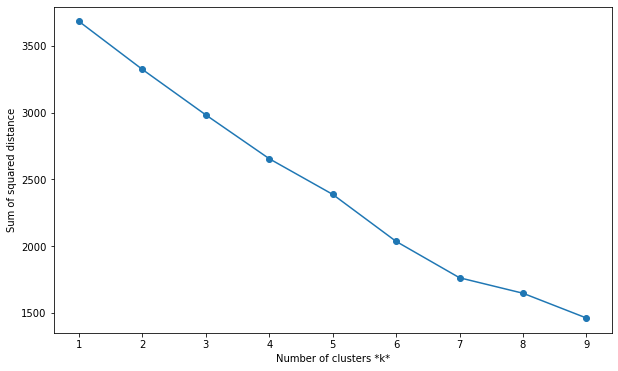

In [109]:
# Run Kmeans algorithm and get the best k

sse = []
list_k = list(range(1,10))

for k in list_k:
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(cluster_dataset)
    sse.append(kmeans.inertia_)
    
# Plot SSE vs k

plt.figure(figsize=(10,6))
plt.plot(list_k,sse,'-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
print('The best k = 6')

## 4.3. k-means algorithm as our model 

In [110]:
# set number of clusters
kclusters = 6

hotels_grouped_clustering = cluster_dataset

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hotels_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 1, 2, 0, 1, 4, 1, 3, 2], dtype=int32)

### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each hotel.

In [111]:
# add clustering labels
hotels_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hotels_merged = coord_hotels

# merge hotels_merged with hotels_venues_sorted to add latitude/longitude for each hotel
hotels_merged = hotels_merged.join(hotels_venues_sorted.set_index('Hotel'), on='Hotel')

In [112]:
hotels_merged.head()

,Hotel,Price,rooms,Address,Zip code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aria,high,4000,3730 S. Las Vegas,89158,36.107035,-115.177976,1,Lounge,Spanish Restaurant,Italian Restaurant,Cocktail Bar,Steakhouse,Sushi Restaurant,Buffet,Seafood Restaurant,Spa,Bar
1,Bally's,medium,2800,3645 S. Las Vegas,89109,36.113784,-115.169011,2,French Restaurant,Steakhouse,Cocktail Bar,American Restaurant,Gift Shop,Hotel Bar,Italian Restaurant,Burger Joint,Bar,Lounge
2,Bellagio,high,4000,3600 S. Las Vegas,89109,36.113115,-115.177006,1,Lounge,Italian Restaurant,French Restaurant,Spa,Japanese Restaurant,Cocktail Bar,Steakhouse,Buffet,Burger Joint,Beer Garden
3,Caesars Palace,high,4000,3570 S. Las Vegas,89109,36.116628,-115.176757,2,Italian Restaurant,Clothing Store,Lounge,Bar,Women's Store,American Restaurant,French Restaurant,Cosmetics Shop,Boutique,Lingerie Store
4,Circus Circus,medium,3800,2880 S. Las Vegas,89109,36.137720,-115.165846,0,Bar,Fast Food Restaurant,American Restaurant,Arcade,Gym,Convenience Store,Coffee Shop,Donut Shop,Sandwich Place,Snack Place


### To finish, let's visualize the resulting clusters

In [113]:
# create map
map_clusters = folium.Map(location=[36.1175584, -115.2014624], zoom_start=11) # Vegas Strip coordinates

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotels_merged['Latitude'], hotels_merged['Longitude'], hotels_merged['Hotel'], hotels_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

# Let's view information of the groups (Clusters)

## Detailed information by cluster 

## Cluster 0 
Common: (Restaurants, Foods) Not common: Arcade, Gym, Bar

In [115]:
hotels_merged.loc[hotels_merged['Cluster Labels'] == 0, hotels_merged.columns[[0] + list(range(1, hotels_merged.shape[1]))]]

,Hotel,Price,rooms,Address,Zip code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Circus Circus,medium,3800,2880 S. Las Vegas,89109,36.13772,-115.165846,0,Bar,Fast Food Restaurant,American Restaurant,Arcade,Gym,Convenience Store,Coffee Shop,Donut Shop,Sandwich Place,Snack Place


## Cluster 1
Common: (Restaurants, Foods, Bar, Lounge, Spa) Not common: Clothing Store, Nightclub, Boutique, Leather goods store, Lingerie Store

In [116]:
hotels_merged.loc[hotels_merged['Cluster Labels'] == 1, hotels_merged.columns[[0] + list(range(1, hotels_merged.shape[1]))]]

,Hotel,Price,rooms,Address,Zip code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aria,high,4000,3730 S. Las Vegas,89158,36.107035,-115.177976,1,Lounge,Spanish Restaurant,Italian Restaurant,Cocktail Bar,Steakhouse,Sushi Restaurant,Buffet,Seafood Restaurant,Spa,Bar
2,Bellagio,high,4000,3600 S. Las Vegas,89109,36.113115,-115.177006,1,Lounge,Italian Restaurant,French Restaurant,Spa,Japanese Restaurant,Cocktail Bar,Steakhouse,Buffet,Burger Joint,Beer Garden
5,Cosmopolitan,high,3000,3708 S. Las Vegas,89109,36.110157,-115.174091,1,Lounge,Seafood Restaurant,French Restaurant,Steakhouse,Spa,Spanish Restaurant,Sushi Restaurant,Chinese Restaurant,Wings Joint,Italian Restaurant
7,Encore at Wynn,high,2000,3131 S. Las Vegas,89109,36.128934,-115.165362,1,American Restaurant,Boutique,Café,Italian Restaurant,Clothing Store,Nightclub,Sushi Restaurant,Spa,New American Restaurant,Leather Goods Store
18,Paris,medium,3200,3655 S. Las Vegas,89109,36.112162,-115.170631,1,Lounge,Italian Restaurant,Bar,Hotel Bar,French Restaurant,Pizza Place,Burger Joint,Steakhouse,Cocktail Bar,American Restaurant
20,Planet Hollywood,medium,2600,3667 S. Las Vegas,89109,36.110062,-115.171513,1,Lounge,French Restaurant,Seafood Restaurant,Chinese Restaurant,Spanish Restaurant,Bar,Pizza Place,American Restaurant,Sushi Restaurant,Café
25,Vdara,high,1500,2600 W Harmon Avenue,89158,36.109465,-115.178053,1,Lounge,Café,Spa,Spanish Restaurant,Sushi Restaurant,Chinese Restaurant,Italian Restaurant,Boutique,Cocktail Bar,Bar
27,Waldorf Astoria,high,400,3752 S. Las Vegas,89109,36.106164,-115.174354,1,Lounge,Cocktail Bar,Steakhouse,Seafood Restaurant,Gift Shop,Pharmacy,Burger Joint,Italian Restaurant,Clothing Store,French Restaurant
28,Wynn,high,2700,3131 S. Las Vegas,89109,36.126572,-115.166042,1,Italian Restaurant,Clothing Store,American Restaurant,Steakhouse,Boutique,Nightclub,Spa,Lounge,Sushi Restaurant,Lingerie Store


## Cluster 2
(Restaurants, Foods, Bar, Clothing Store, Nightclub) Not common: Jewelry Store, Cosmetics Shop, Pharmacy, Lingerie Store, Women's Store

In [117]:
hotels_merged.loc[hotels_merged['Cluster Labels'] == 2, hotels_merged.columns[[0] + list(range(1, hotels_merged.shape[1]))]]

,Hotel,Price,rooms,Address,Zip code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bally's,medium,2800,3645 S. Las Vegas,89109,36.113784,-115.169011,2,French Restaurant,Steakhouse,Cocktail Bar,American Restaurant,Gift Shop,Hotel Bar,Italian Restaurant,Burger Joint,Bar,Lounge
3,Caesars Palace,high,4000,3570 S. Las Vegas,89109,36.116628,-115.176757,2,Italian Restaurant,Clothing Store,Lounge,Bar,Women's Store,American Restaurant,French Restaurant,Cosmetics Shop,Boutique,Lingerie Store
9,Flamingo,medium,3700,3555 S. Las Vegas,89109,36.116425,-115.172364,2,Italian Restaurant,American Restaurant,Lounge,Bar,French Restaurant,Steakhouse,Hotel Bar,Japanese Restaurant,Nightclub,Pizza Place
10,Harrah's,medium,2700,3475 S. Las Vegas,89109,36.119303,-115.171162,2,American Restaurant,Italian Restaurant,Steakhouse,Nightclub,Bar,Cocktail Bar,Hotel Bar,Seafood Restaurant,Gift Shop,Burger Joint
11,The Linq,medium,2700,3535 S. Las Vegas,89109,36.118359,-115.170597,2,American Restaurant,Bar,Hotel Bar,Italian Restaurant,Steakhouse,Lounge,Cocktail Bar,Nightclub,Pizza Place,Mexican Restaurant
15,Mirage,medium,3000,3400 S. Las Vegas,89109,36.121746,-115.175126,2,Clothing Store,Cocktail Bar,Steakhouse,Bar,Italian Restaurant,Lingerie Store,Nightclub,Women's Store,Hotel Bar,Leather Goods Store
17,Palazzo,high,3000,3265 S. Las Vegas,89109,36.123995,-115.168094,2,Italian Restaurant,Steakhouse,American Restaurant,Café,Burger Joint,Gift Shop,Cocktail Bar,Bar,Japanese Restaurant,Department Store
23,Treasure Island,medium,2900,3300 S. Las Vegas,89109,36.124617,-115.171976,2,Steakhouse,Italian Restaurant,Department Store,Clothing Store,Nightclub,Mexican Restaurant,Cosmetics Shop,Café,Gift Shop,Japanese Restaurant
26,Venetian,high,4000,3355 S. Las Vegas,89109,36.121721,-115.169335,2,Steakhouse,American Restaurant,Italian Restaurant,Cocktail Bar,Nightclub,Hotel Bar,Bar,Pharmacy,Pizza Place,Burger Joint


## Cluster 3
Common: (Restaurants, Foods, Bar, Gym, Candy Store, Spa) Not Common: Pharmacy, Nightclub, Irish Pub

In [118]:
hotels_merged.loc[hotels_merged['Cluster Labels'] == 3, hotels_merged.columns[[0] + list(range(1, hotels_merged.shape[1]))]]

,Hotel,Price,rooms,Address,Zip code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Excalibur,medium,4000,3850 S. Las Vegas,89109,36.098873,-115.175608,3,Cocktail Bar,Bar,Pizza Place,Steakhouse,Burger Joint,Spa,Deli / Bodega,Chinese Restaurant,Comfort Food Restaurant,Pub
13,MGM Grand,high,5000,3799 S. Las Vegas,89109,36.102790,-115.169399,3,Pizza Place,American Restaurant,Bar,Cocktail Bar,Steakhouse,Gift Shop,Nightclub,Burger Joint,Spa,Clothing Store
16,New York New York,medium,2000,3790 S. Las Vegas,89109,36.102144,-115.174495,3,Bar,American Restaurant,Pizza Place,Burger Joint,French Restaurant,Clothing Store,Candy Store,Steakhouse,Pharmacy,Italian Restaurant
19,Park MGM,medium,2700,3770 S. Las Vegas .,89109,36.104760,-115.175378,3,Steakhouse,Bar,Burger Joint,Gift Shop,Lounge,Candy Store,Cocktail Bar,Clothing Store,French Restaurant,Irish Pub
24,Tropicana,medium,1900,3801 S. Las Vegas,89109,36.099146,-115.171839,3,American Restaurant,Bar,Pizza Place,Steakhouse,Cocktail Bar,Candy Store,French Restaurant,Burger Joint,Snack Place,Spa


## Cluster 4
Common: (Restaurants, Foods, Bar,Lounge,Gift Shop)  Not common: Gym, Music Venue, Salon/Barbershop, Rental Car

In [120]:
hotels_merged.loc[hotels_merged['Cluster Labels'] == 4, hotels_merged.columns[[0] + list(range(1, hotels_merged.shape[1]))]]

,Hotel,Price,rooms,Address,Zip code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Delano,high,1100,3950 S. Las Vegas,89119,36.092639,-115.177773,4,Lounge,Cocktail Bar,Gift Shop,Mexican Restaurant,Coffee Shop,Italian Restaurant,Steakhouse,Pizza Place,Nightclub,American Restaurant
12,Luxor,medium,4400,3900 S. Las Vegas,89119,36.095872,-115.175807,4,Gift Shop,Cocktail Bar,Lounge,Gym,Pizza Place,Nightclub,Music Venue,Salon / Barbershop,Russian Restaurant,Rental Car Location
14,Mandalay Bay,high,3300,3950 S. Las Vegas,89119,36.091963,-115.177131,4,Nightclub,Cocktail Bar,American Restaurant,Lounge,Italian Restaurant,Pizza Place,Mexican Restaurant,Coffee Shop,Gift Shop,Steakhouse


## Cluster 5
Common: (Restaurants, Foods, Bar, Convenience Store)  Not common: Gift Shop, Gym

In [121]:
hotels_merged.loc[hotels_merged['Cluster Labels'] == 5, hotels_merged.columns[[0] + list(range(1, hotels_merged.shape[1]))]]

,Hotel,Price,rooms,Address,Zip code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Sahara,medium,1600,2535 S. Las Vegas,89109,36.142342,-115.156912,5,Convenience Store,Restaurant,Steakhouse,Sandwich Place,Gym,French Restaurant,Mediterranean Restaurant,Coffee Shop,Cocktail Bar,Pharmacy
22,Strat,medium,1500,2000 S. Las Vegas,89103,36.146995,-115.156564,5,Convenience Store,American Restaurant,Gift Shop,Cocktail Bar,Mexican Restaurant,Fast Food Restaurant,Asian Restaurant,Pharmacy,Coffee Shop,Cantonese Restaurant


## Graphic information of the clusters 

([<matplotlib.axis.YTick at 0x7f6f46427450>,
 <a list of 10 Text major ticklabel objects>)

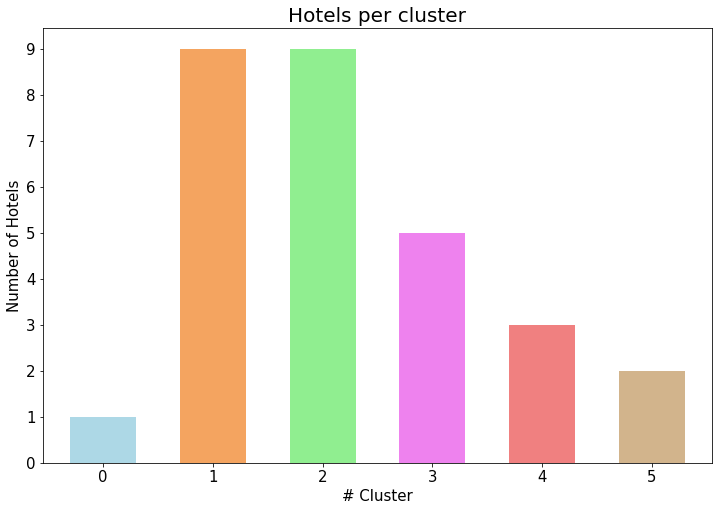

In [151]:
cluster_hot = hotels_merged.groupby(['Cluster Labels'])['Hotel'].count()

cluster_hot.plot.bar(figsize=(12,8),fontsize=15,width=0.6,rot= .70,color=("lightblue","sandybrown","lightgreen","violet","lightcoral","tan"))

plt.title('Hotels per cluster', fontsize=20)
plt.ylabel('Number of Hotels',fontsize=15)
plt.xlabel('# Cluster',fontsize=15)
plt.yticks(np.arange(0,10, step=1))

### We are going to visualize the first 3 most common venues per cluster 

Text(0.5, 0, 'Frecuency')

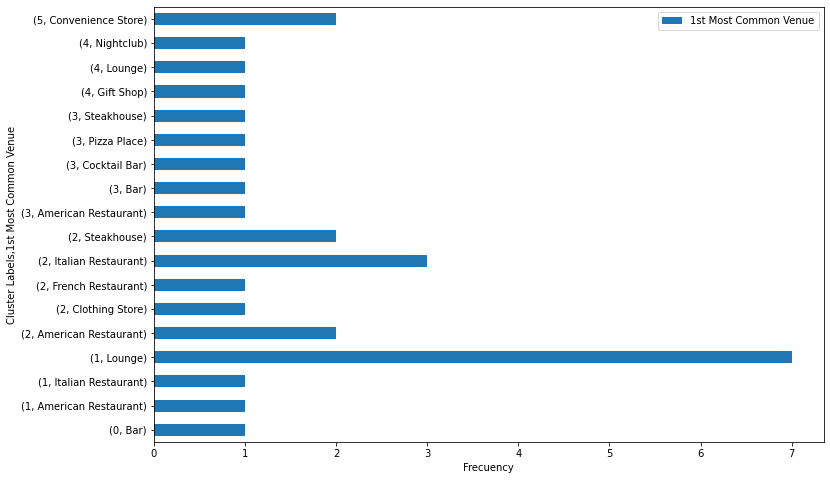

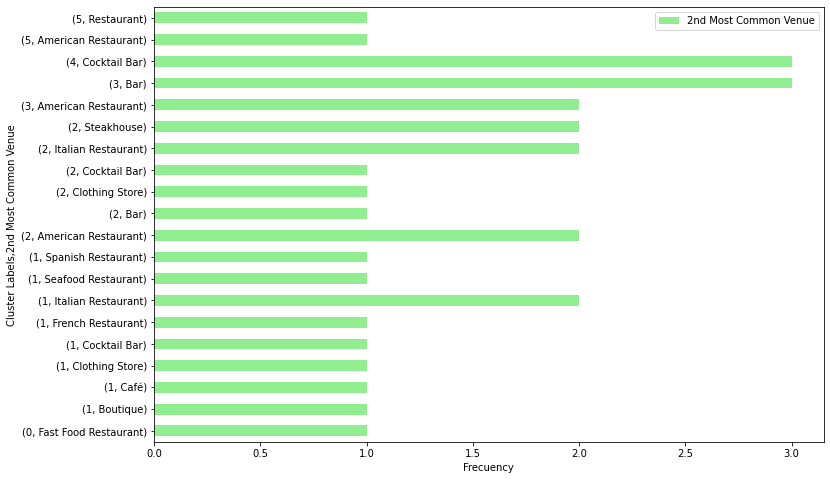

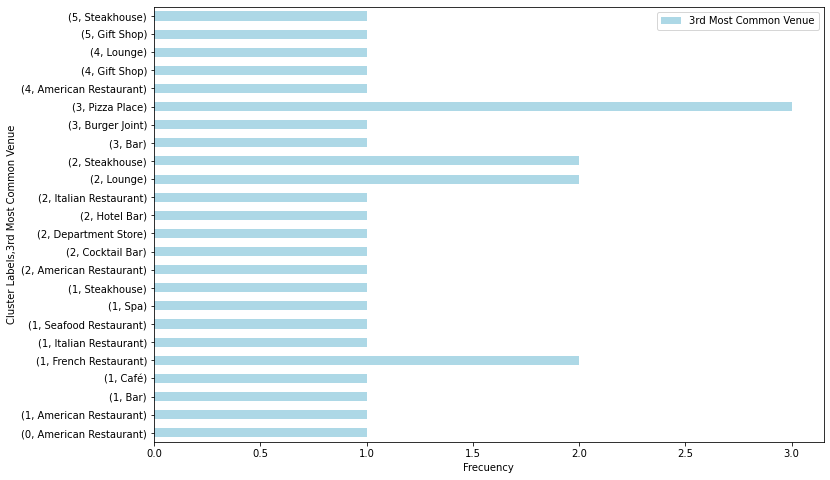

In [131]:
# Let's create dataframe using Cluster Labels and Most Common Venue feature
cluster_buss = hotels_merged.iloc[:,7:].set_index('Cluster Labels')

# Now, let's visualize venues per cluster
cluster_buss.groupby(['Cluster Labels','1st Most Common Venue']
                    )[['1st Most Common Venue']].count().plot.barh(figsize=(12,8)); plt.xlabel('Frecuency')

cluster_buss.groupby(['Cluster Labels','2nd Most Common Venue']
                    )[['2nd Most Common Venue']].count().plot.barh(figsize=(12,8), color='lightgreen'); plt.xlabel('Frecuency')

cluster_buss.groupby(['Cluster Labels','3rd Most Common Venue']
                    )[['3rd Most Common Venue']].count().plot.barh(figsize=(12,8), color='lightblue'); plt.xlabel('Frecuency')


# Thanks for watching this project